In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import xgboost as xgb
from xgboost import XGBRegressor


In [26]:
from sklearn.model_selection import train_test_split

# # Data inladen
df = pd.read_csv("final_df.csv")
print(df.head())
# df = groot_gemid_df

# Eerst de data opschudden om bias te voorkomen
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Zorg ervoor dat elke ervaring, geslacht en gewichtsklasse in elke set vertegenwoordigd zijn
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for ervaring in df['ervaring'].unique():
    for geslacht in df['binary_geslacht'].unique():
        for gewichtsklasse in df['binary_gewichtsklasse'].unique():
            subset = df[(df['ervaring'] == ervaring) & (df['binary_geslacht'] == geslacht) & (df['binary_gewichtsklasse'] == gewichtsklasse)]
            if not subset.empty:
                temp_train, temp_temp = train_test_split(subset, test_size=0.3, random_state=42)
                temp_val, temp_test = train_test_split(temp_temp, test_size=0.3, random_state=42)
                train_data = pd.concat([train_data, temp_train])
                val_data = pd.concat([val_data, temp_val])
                test_data = pd.concat([test_data, temp_test])

# Reset indexen
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Controleren op juiste verdeling
print(f"Trainingsdata: {len(train_data)} rijen")
print(f"Validatiedata: {len(val_data)} rijen")
print(f"Testdata: {len(test_data)} rijen")

# # Optioneel: data opslaan in aparte bestanden
# train_data.to_csv('train_data.csv', index=False)
# val_data.to_csv('val_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

print(df['2k tijd'].min())
print(df['2k tijd'].max())

   ervaring  500_split  2k tijd  binary_trainingtype  binary_geslacht  \
0         1      104.6    379.9                    0                0   
1         1      104.7    379.9                    0                0   
2         1      104.3    379.9                    0                0   
3         1      104.0    379.9                    0                0   
4         1      104.1    379.9                    0                0   

   binary_gewichtsklasse  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
Trainingsdata: 3018 rijen
Validatiedata: 905 rijen
Testdata: 391 rijen
371.8
510.1


In [27]:
def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse_scorer, greater_is_better=False)

X_train = train_data.drop(columns=['2k tijd'])
y_train = train_data['2k tijd']

X_val = val_data.drop(columns=['2k tijd'])
y_val = val_data['2k tijd']

X_test = test_data.drop(columns=['2k tijd'])
y_test = test_data['2k tijd']

def feature_engineering(df):
    df['interaction_split_training'] = df['500_split'] * df['binary_trainingtype']
    df['interaction_split_geslacht'] = df['500_split'] * df['binary_geslacht']
    df['interaction_split_ervaring'] = df['500_split'] * df['ervaring']
    # df['interaction_split_gewicht'] = df['500_split'] * df['binary_gewichtsklasse']
    if '500_split' in df.columns:
        df['log_500_split'] = np.log1p(df['500_split'])  # Log-transform to reduce skewness
    return df

X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)

# StratifiedKFold for balanced splits
kf = KFold(n_splits=3, shuffle=True, random_state=42)

Cross-Validated RMSE: -7.976
mse_train = 39.38663313515027
mse_val = 64.0821094291212
mse_test = 50.04622143391854
rmse_test = 7.074335405811527
train_r2 = 0.9620963575925102
val_r2 = 0.9373556589216944
test_r2 = 0.9512655406185849
   Actual 2k tijd  Predicted 2k tijd (XGBoost)  Difference (XGBoost)
0           427.7                   419.682129              8.017871
1           420.5                   426.861481             -6.361481
2           418.6                   422.420197             -3.820197
3           427.7                   425.157593              2.542407
4           427.7                   425.846893              1.853107
5           420.5                   423.480438             -2.980438
6           421.9                   419.805847              2.094153
7           449.0                   431.543793             17.456207
8           431.6                   429.530121              2.069879
9           431.6                   423.600403              7.999597


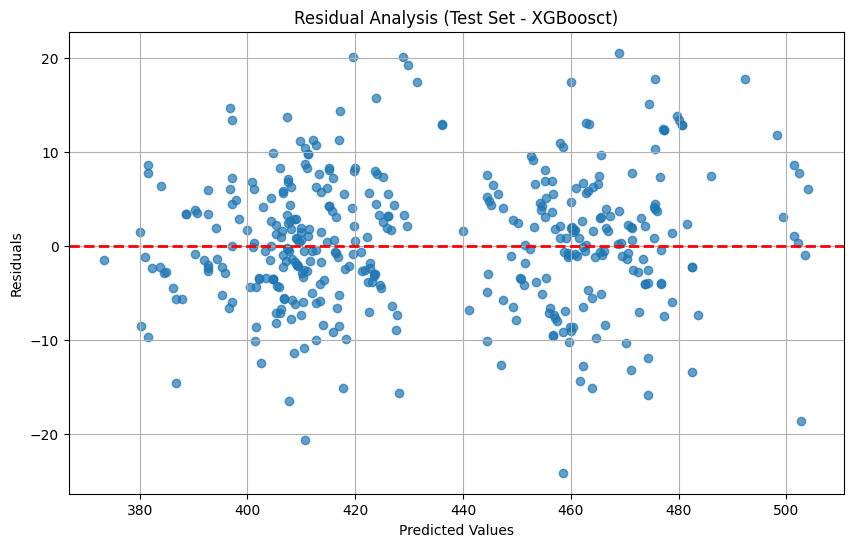

<Figure size 1000x600 with 0 Axes>

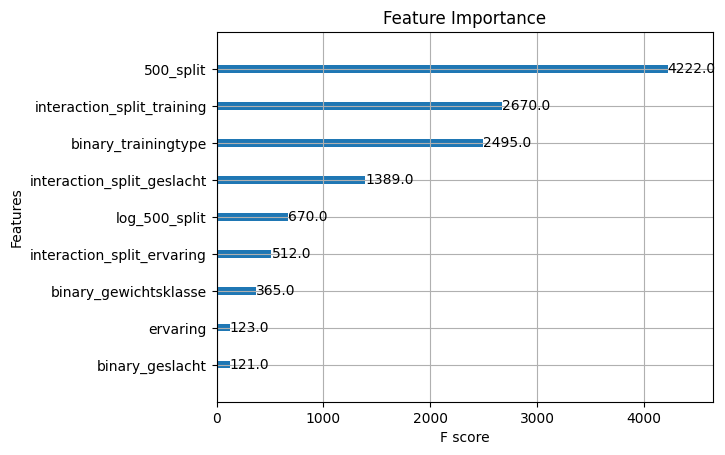

Test RMSE: 7.074335405811527


<Figure size 2000x1000 with 0 Axes>

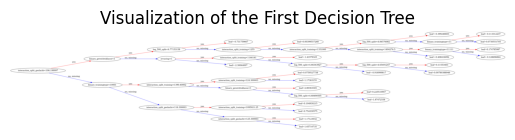

<Figure size 2000x1000 with 0 Axes>

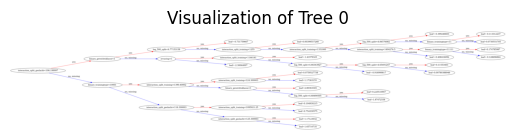

<Figure size 2000x1000 with 0 Axes>

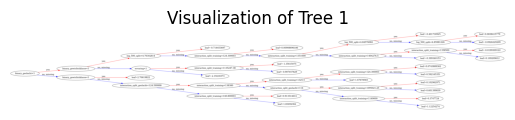

<Figure size 2000x1000 with 0 Axes>

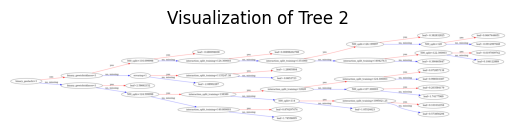

In [30]:
xgb_model = XGBRegressor(objective="reg:squarederror", 
                             random_state=42, 
                             reg_lambda=10,
                             min_child_weight=3, 
                             colsample_bytree=0.8, 
                             learning_rate=0.05, 
                             max_depth=7, 
                             n_estimators=300)

xgb_model.fit(X_train, y_train)

train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)
val_pred = xgb_model.predict(X_val)

cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring=scorer, cv=kf)
print(f"Cross-Validated RMSE: {-np.mean(cv_scores):.3f}")

mse_train = mean_squared_error(y_train, train_pred)
mse_val = mean_squared_error(y_val, val_pred)
mse_test = mean_squared_error(y_test, test_pred)
print(f"mse_train = {mse_train}")
print(f"mse_val = {mse_val}")
print(f"mse_test = {mse_test}")

rmse_test = np.sqrt(mse_test)
print(f"rmse_test = {rmse_test}")

# example_input = np.array([[1, 104.6, 0, 0, 1]])
# example_prediction = xgb_model.predict(example_input)
# print(f"Example prediction: {example_prediction}")

train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"train_r2 = {train_r2}")
print(f"val_r2 = {val_r2}")
print(f"test_r2 = {test_r2}")

results_xgb = pd.DataFrame({
    'Actual 2k tijd': y_test,
    'Predicted 2k tijd (XGBoost)': test_pred,
    'Difference (XGBoost)': y_test - test_pred
})
print(results_xgb.head(10))

### plot for the validation set
# plt.figure(figsize=(10, 6))
# plt.scatter(y_val, val_pred, alpha=0.7, label='Predicted vs Actual (XGBoost)')
# plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Validation Set: Predicted vs Actual (XGBoost)')
# plt.legend()
# plt.grid(True)
# plt.show()

### plot for the test set
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, test_pred, alpha=0.7, label='Predicted vs Actual (XGBoost)')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
# plt.xlabel('Actual Values')
# plt.ylabel('Predicted Values')
# plt.title('Test Set: Predicted vs Actual (XGBoost)')
# plt.legend()
# plt.grid(True)
# plt.show()

### plotting the actual vs predicted values for the test set
import plotly.express as px
import plotly.graph_objects as go

data = pd.DataFrame({'Actual': y_test, 'Predicted': test_pred})
fig = px.scatter(data, x='Actual', y='Predicted', title="Actual vs Predicted Values (Test Set)")
min_val = min(data['Actual'].min(), data['Predicted'].min())
max_val = max(data['Actual'].max(), data['Predicted'].max())
fig.add_trace(go.Scatter(x=[min_val, max_val], y=[min_val, max_val], mode='lines', 
                         name='Perfect Prediction', line=dict(color='red')))
fig.show()

### plotting the residuals for the test set
residuals_xgb = y_test - test_pred
plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals_xgb, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis (Test Set - XGBoosct)')
plt.grid(True)
plt.show()

### feature analysis
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("Feature Importance")
plt.show()

test_pred = xgb_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test RMSE:", test_rmse)

from xgboost import plot_tree
import matplotlib.pyplot as plt

# Visualize the first tree in the XGBoost model
plt.figure(figsize=(20, 10))
plot_tree(xgb_model, num_trees=0, rankdir='LR')  # num_trees=0 visualizes the first tree
plt.title("Visualization of the First Decision Tree")
plt.show()

# To visualize more trees, loop through and plot them
num_trees_to_plot = 3  # Adjust this to control the number of trees to visualize
for i in range(num_trees_to_plot):
    plt.figure(figsize=(20, 10))
    plot_tree(xgb_model, num_trees=i, rankdir='LR')
    plt.title(f"Visualization of Tree {i}")
    plt.show()


In [29]:
param_grid = {'reg_lambda': [0.1, 1, 10, 100, 150, 500], 
              'min_child_weight': [1, 3, 5, 7, 9, 12], 
              'colsample_bytree': [0.6, 0.8, 1.0],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5],
              'max_depth': [3, 5, 7],
              'n_estimators': [100, 200, 300, 400, 500]}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_lambda = grid_search.best_params_['reg_lambda']
best_min_child_weight = grid_search.best_params_['min_child_weight']
best_colsample = grid_search.best_params_['colsample_bytree']
best_learningrate = grid_search.best_params_['learning_rate']
best_maxdepth = grid_search.best_params_['max_depth']
best_nestimators = grid_search.best_params_['n_estimators']
print('Best lambda (reg_lambda):', best_lambda)
print('Best child weight:', best_min_child_weight)
print('Best colsample:', best_colsample)
print('Best learning rate:', best_learningrate)
print('Best maxdepth:', best_maxdepth)
print('Best estimators:', best_nestimators)


Best lambda (reg_lambda): 10
Best child weight: 3
Best colsample: 0.8
Best learning rate: 0.05
Best maxdepth: 7
Best estimators: 200


In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Data loading and splitting
df = pd.read_csv("final_df.csv")

# Shuffle the data to avoid any bias
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Initialize empty DataFrames for train, validation, and test sets
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

# Split data ensuring that experience, gender, and weight class are represented in each set
for ervaring in df['ervaring'].unique():
    for geslacht in df['binary_geslacht'].unique():
        for gewichtsklasse in df['binary_gewichtsklasse'].unique():
            subset = df[(df['ervaring'] == ervaring) & 
                        (df['binary_geslacht'] == geslacht) & 
                        (df['binary_gewichtsklasse'] == gewichtsklasse)]
            if not subset.empty:
                temp_train, temp_temp = train_test_split(subset, test_size=0.3, random_state=42)
                temp_val, temp_test = train_test_split(temp_temp, test_size=0.3, random_state=42)
                train_data = pd.concat([train_data, temp_train])
                val_data = pd.concat([val_data, temp_val])
                test_data = pd.concat([test_data, temp_test])

# Reset indices
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Split features and target
X_train = train_data.drop(columns=['2k tijd'])
y_train = train_data['2k tijd']

X_val = val_data.drop(columns=['2k tijd'])
y_val = val_data['2k tijd']

X_test = test_data.drop(columns=['2k tijd'])
y_test = test_data['2k tijd']

# Baseline Model
baseline_model = XGBRegressor(random_state=42, n_estimators=100)
baseline_model.fit(X_train, y_train)

# Baseline Metrics
val_preds = baseline_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = mean_squared_error(y_val, val_preds, squared=False)
val_r2 = r2_score(y_val, val_preds)

print(f"Baseline Validation MSE: {val_mse}")
print(f"Baseline Validation RMSE: {val_rmse}")
print(f"Baseline Validation R2: {val_r2}")

# Hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [200, 300, 400],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Extract best parameters from GridSearchCV
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Create a new XGBRegressor with the best parameters
best_model = XGBRegressor(**best_params, random_state=42)

# Retrain the model with early stopping
best_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    # early_stopping_rounds=50,
    verbose=False
)

# Evaluate the final model on the test set
test_preds = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = mean_squared_error(y_test, test_preds, squared=False)
test_r2 = r2_score(y_test, test_preds)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R2: {test_r2}")

# Feature Importance Analysis
importance = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

# Cross-Validation to Validate Generalization
cv_scores = cross_val_score(
    best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'
)
cv_rmse = np.sqrt(-cv_scores)
print(f"Cross-Validation RMSE Scores: {cv_rmse}")
print(f"Mean CV RMSE: {cv_rmse.mean()}")

# Residual Analysis
residuals = y_test - test_preds
print("Residual Analysis:")
print(f"Mean Residual: {np.mean(residuals)}")
print(f"Residual Std Dev: {np.std(residuals)}")



/home/jade/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Baseline Validation MSE: 66.50744379765271
Baseline Validation RMSE: 8.155209610896136
Baseline Validation R2: 0.9349847401931329
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 8, 'n_estimators': 400, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}


/home/jade/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Test MSE: 51.96911578034244
Test RMSE: 7.208960797531253
Test R2: 0.9493930472767192
Feature Importance:
                 Feature  Importance
3        binary_geslacht    0.956591
4  binary_gewichtsklasse    0.026684
0               ervaring    0.014606
2    binary_trainingtype    0.001408
1              500_split    0.000710
Cross-Validation RMSE Scores: [11.59295916  7.49497148 10.6410846   8.62183265 10.40775188]
Mean CV RMSE: 9.75171995409973
Residual Analysis:
Mean Residual: 0.4135118255224988
Residual Std Dev: 7.197091339596538
